If you are an investor in stocks or bonds you are likely always looking for ways to increase your return or lower your risk, and it turns out there is a way to do both simultaneously called rebalancing. Portfolio rebalancing is something every investor should either do themselves or have done for them. Registered investment advisors like Vanguard and others will provide this service as part of an active management agreement, while robo-advisors such as Betterment will also rebalance automatically. To understand why it's so important, I'll defer to the finance professionals over at [BogleHeads](https://www.bogleheads.org/wiki/Rebalancing) :

>Rebalancing is the action of bringing a portfolio that has deviated away from one's target asset allocation back into line. The objective is to maintain a consistent mix of asset classes (most commonly equities vs. fixed income) in order to control risk at the level desired by the investor. This is accomplished by transferring funds from higher-performing classes to lower-performing classes. While potentially counterintuitive, rebalancing ensures that investors "Buy Low" and "Sell High".

Much research has been conducted on the benefits of portoflio rebalancing, here is an excerpt from a fairly recent [Morgan Stanley](https://www.morganstanley.com/articles/rebalancing-effect) research piece:

>Rebalancing takes advantage of the long-term effects of mean reversion. By lightening up on stocks after periods of significant outperformance, or topping off positions after periods of underperformance, this discipline helps take advantage of volatility to benefit from these swings. ... A disciplined approach to rebalancing portfolios annually can create additional return and lower volatility versus never rebalancing or rebalancing during different time periods. While investing for the long term requires patience, a disciplined approach to rebalancing can help create value beyond the cyclical trends of the market.

Timely and consistent rebalancing has become a cornerstone of modern portfolio theory. Rebalancing can magnify returns by promoting selling high and buying low, and reduce long-term risk by ensuring the portfolio adheres to its designated risk tolerance. The keys are to rebalance in a timely manner (i.e. annually) and to do it consistently because the benefits of rebalancing compound over time - but rebalancing by hand is a pain, and that can lead to inconsistency. I pursued this project due to the lack of free tools to simply rebalance an existing portfolio. Sure, we can all use a worksheet to do the math each time, but why not automate it to make it more likely we will actually do it? Here, inspired by the work of [kdboller](https://nbviewer.jupyter.org/github/kdboller/pythonsp500/blob/a7066d998ff046c3cc8b26ece3b0efdf00959d57/Investment%20Portfolio%20Python%20Notebook_03_2018_blog%20example.ipynb), I'll use Pandas, the Tiingo API, and some simple math to calculate how to optimally rebalance a portfolio given a target allocation. This is a simple, no-frills portfolio rebalancing exercise which does not factor in important considerations such as tax efficiency, transaction costs, minimum investment amounts, or alternate approaches such as stock-out rebalances, or bond-floor settings. Future versions of this project may contemplate these extra factors.  

My portfolio is spread across various accounts and asset classes, so at a minimum this portfolio rebalancer had to consider how to best allocate assets within and across accounts. If new assets were added to the portfolio (based on the target portfolio definition) the rebalancer must also handle distributing those new assets into an existing account with adequate funds for it. A final consideration was basic asset tax location, I wanted the distribution of new assets to prioritize the appropriate accounts, for example, bonds will go in tax-free or tax-deferred acounts first and only to taxable accounts as a last resort. The reason for this tax location is bonds and bond funds are taxed as regular income (a higher rate) versus stocks which are taxed as capital gains (a lower rate) so we would generally prefer the higher taxed asset to be placed in a tax-advantaged account. The account-level distribution logic is constrained by available funds from sales in that same account, this is a simplifying constraint because the code does not currently contemplate IRA or Roth-IRA contribution levels or limits, and as a practical matter manually moving additional funds into a 401k may be impossible. Unfortunately, these additional considerations add to complexity and code length but I felt leaving them out would be too oversimplified and not actually useful for an average portfolio like my own.

The steps and static code are below, but thanks to the amazing folks over at [Binder](https://mybinder.org/) you can run this code interactively right in your browser and play with the rebalancer in real-time and change the inputs to suit your needs. Click the launch Binder link below to launch a new window which will load the code environment (it takes a few minutes).  
 
<a href="https://mybinder.org/v2/gh/pogoetic/rebalance/master?filepath=portfolio_rebalance.ipynb" target="_blank"><img src="https://mybinder.org/badge_logo.svg"></a>

**Steps:** 
1. Set triggers to rebalance (time or threshold or both)
2. Define our current Portfolio (accounttype, accountid, lastrebaldate, ticker, shares, cost basis, assetclass)  
3. Define our target allocation (ticker, allocation, assetclass)  
4. Factor in any new money being invested  
5. Aggregate to security level and calculate rebalance triggers to determine which securities must be rebalanced
6. Calculate initial transactions needed to hit target allocation (1 row per ticker)
7. Disaggregate portfolio back to account level (1 row per ticker per account)
8. Iteratively distribute new securities into accounts, keeping tax location in mind
9. Iteratively distribute across accounts any new securities which do not fit into a single account


**References:**

[pythonsp500 by kdboller](https://nbviewer.jupyter.org/github/kdboller/pythonsp500/blob/a7066d998ff046c3cc8b26ece3b0efdf00959d57/Investment%20Portfolio%20Python%20Notebook_03_2018_blog%20example.ipynb)

[Portfolio Rebalancing by bogleheads wiki](https://www.bogleheads.org/wiki/Rebalancing)

[The Rebalancing Effect by Morgan Stanely](https://www.morganstanley.com/articles/rebalancing-effect)  



**Github Repo:**
[pogoetic/rebalance](https://github.com/pogoetic/rebalance)

## Code

In [2]:
#Lets import the necessary packages
import pandas as pd
from IPython.display import display
pd.set_option('display.max_columns', None)
import numpy as np
import datetime
import decimal
from pandas_datareader import data as pdr
from keys import tiingo_key
#define todays datetime
now = datetime.datetime.now()

In [3]:
#Settings
new_money_in = 10000
#Set our rebalance threshold
rebal_threshold = .05 #allowable allocation drift
rebal_timeframe = 180 #in days

In [4]:
#Define target and current allocations
#create our target allocation
columns_t = ['ticker','allocation_target','assetclass']
positions_t = [['VTSAX',0.5652,'ST'],
               ['VIGAX',0.0131,'ST'],
               ['VSMAX',0.0066,'ST'],
               ['VSEQX',0.0066,'ST'],
               ['VWIGX',0.0507,'ST'],
               ['VTRIX',0.0507,'ST'],
               ['VTIAX',0.1521,'ST'],
               ['VBTLX',0.035,'BD'],
               ['VTABX',0.015,'BD'],
               ['VGSLX',0.05,'RE'],
               ['VNQI',0.01,'RE'],
               ['VDE',0.03,'ST'],
               ['GLD',0.015,'CS']]

#set our current portfolio
columns_c = ['accounttype','accountid','lastrebaldate','ticker','assetclass','basisdate','costbasis','shares']
positions_c = [['RIRA','1111','2018-11-16','VBTLX','BD','2018-11-16',1,913.483],
             ['RIRA','1111','2018-11-16','VTIAX','ST','2018-11-16',1,514.298],
             ['RIRA','1111','2018-11-16','VTSAX','ST','2018-11-16',10,151.121],
             ['RIRA','2222','2018-11-16','VBTLX','BD','2018-11-16',1,772.407],
             ['RIRA','2222','2018-11-16','VTSAX','ST','2018-11-16',20,151.578],
             ['TAXB','3333','2018-11-16','AAPL','ST','2018-11-16',1,3.14],
             ['TAXB','3333','2018-11-16','VTSAX','ST','2018-11-16',10,549.871]]

In [5]:
#lookup table for account type abbreviations
accounttypes = {'TAXB':'Taxable Brokerage', '401K':'401k', 'RIRA':'Roth-IRA', 'TIRA':'Traditional-IRA'}
assetclasses = {'ST':'Equity Stocks', 'BD':'Bonds Fixed-Income', 'CS':'Cash and Commodities', 'RE':'Real-Estate', 'ALT':'Alternatives'}
assettypes = {'SEC':'Individual Security', 'ETF':'Exchange Traded Fund', 'MF': 'Mutual Fund', 'IF':'Index Fund'}
assetregion = {'D':'Domestic','I':'International'}

#initialize target portfolio
targetalloc = pd.DataFrame(columns = columns_t, data = positions_t)
total=decimal.Decimal(targetalloc.allocation_target.sum())
#check that our target allocation indeed adds to 100%
assert round(total,4) == 1,'Target Allocation not 100% : {}'.format(int(total))

#initialize current portfolio
start_port = pd.DataFrame(columns = columns_c, data = positions_c)
start_port.lastrebaldate = pd.to_datetime(start_port.lastrebaldate)
start_port.basisdate = pd.to_datetime(start_port.basisdate)

#custom apply function
def f(x):
    d = {}
    d['lastrebaldate'] = x['lastrebaldate'].max()
    d['assetclass'] = x['assetclass'].max()
    d['basisdate'] = x['basisdate'].min()
    d['costbasis'] = (x['costbasis'] * x['shares']).sum()/(x['shares'].sum() or 1) #weighted avg
    d['shares'] = x['shares'].sum()
    return pd.Series(d, index=['lastrebaldate', 'assetclass', 'basisdate', 'costbasis', 'shares'])

#aggregate by ticker to account for duplicate securities held in different accounts
agg_port = start_port.groupby(['ticker']).apply(f)

#Define list of distinct tickers we care about
tickers = set(targetalloc.ticker.unique().tolist()+start_port.ticker.unique().tolist())

In [6]:
#Lets look at our input portfolios (target and current)
display(targetalloc)
display(start_port)

#And our aggregated portfolio at the ticker level (1 row per ticker)
display(agg_port)

ticker  allocation_target assetclass
0   VTSAX             0.5652         ST
1   VIGAX             0.0131         ST
2   VSMAX             0.0066         ST
3   VSEQX             0.0066         ST
4   VWIGX             0.0507         ST
5   VTRIX             0.0507         ST
6   VTIAX             0.1521         ST
7   VBTLX             0.0350         BD
8   VTABX             0.0150         BD
9   VGSLX             0.0500         RE
10   VNQI             0.0100         RE
11    VDE             0.0300         ST
12    GLD             0.0150         CS

accounttype accountid lastrebaldate ticker assetclass  basisdate  costbasis  \
0        RIRA      1111    2018-11-16  VBTLX         BD 2018-11-16          1   
1        RIRA      1111    2018-11-16  VTIAX         ST 2018-11-16          1   
2        RIRA      1111    2018-11-16  VTSAX         ST 2018-11-16         10   
3        RIRA      2222    2018-11-16  VBTLX         BD 2018-11-16          1   
4        RIRA      2222    2018-11-16  VTSAX         ST 2018-11-16         20   
5        TAXB      3333    2018-11-16   AAPL         ST 2018-11-16          1   
6        TAXB      3333    2018-11-16  VTSAX         ST 2018-11-16         10   

    shares  
0  913.483  
1  514.298  
2  151.121  
3  772.407  
4  151.578  
5    3.140  
6  549.871

lastrebaldate assetclass  basisdate  costbasis    shares
ticker                                                         
AAPL      2018-11-16         ST 2018-11-16   1.000000     3.140
VBTLX     2018-11-16         BD 2018-11-16   1.000000  1685.890
VTIAX     2018-11-16         ST 2018-11-16   1.000000   514.298
VTSAX     2018-11-16         ST 2018-11-16  11.777895   852.570

In [7]:
#Next we pull the latest prices from Tiingo (YahooFinance is buggy, and IEX does not contain mutual fund data)
#Tiingo limits for free API: 500 unique tickers ever, 500 requests/hr, 20,000 requests/day
#https://pandas-datareader.readthedocs.io/en/latest/remote_data.html#tiingo
#Tiingo API key required: set 'tiingo_key' value in python file called 'keys.py' in same directory as this script
now = datetime.datetime.now()
yesterday = now - datetime.timedelta(3) #avoids weekends with no data - need better weekend detection
start = datetime.datetime(yesterday.year, yesterday.month, yesterday.day)
end = datetime.datetime(now.year, now.month, now.day)

bad_tickers = []
for i, t in enumerate(tickers):
    try:
        if i==0:
            ohlc = pdr.get_data_tiingo(t, api_key=tiingo_key).tail(1).close
        else:
            ohlc = ohlc.append(pdr.get_data_tiingo(t, api_key=tiingo_key).tail(1).close)
    except:
        bad_tickers.append(t)
        
#print(bad_tickers)
ohlc = ohlc.to_frame(name='close')

#drop our date index since its only the latest data
ohlc2=ohlc.reset_index(level=1, drop=True)

#Manual fix for known bad_tickers which Tiingo can't find, adjust to suit your needs
if 'VMFXX' in bad_tickers:
    ohlc2.loc['VMFXX'] = 1.0

In [8]:
#What did we get?
display(ohlc2)

close
symbol        
VTABX    21.66
VIGAX    68.02
VSEQX    26.77
VTIAX    25.17
VNQI     52.05
VWIGX    24.76
VTSAX    61.08
VTRIX    31.91
VBTLX    10.39
VDE      77.44
VSMAX    62.25
AAPL    156.15
VGSLX   105.06
GLD     120.57

In [9]:
#concatenate target allocation and latest prices with our portfolio
start_port_c = pd.merge(agg_port, targetalloc, on ='ticker', how ='outer')
final_port = pd.merge(start_port_c, ohlc2, left_on ='ticker', right_index = True, how = 'left')

#set target to zero for tickers held but not present in our target allocation, set initial basisdate and costbasis for new securities entering the portfolio
final_port.fillna(value = {'allocation_target':0.0,'shares':0.0,'basisdate':pd.to_datetime(now.strftime("%Y-%m-%d")),'costbasis':final_port.close,'assetclass_x':final_port.assetclass_y},inplace = True)
final_port.drop(['assetclass_y'],axis=1,inplace=True)
final_port.rename(columns={'assetclass_x':'assetclass'},inplace=True)

#calculate holding values and current allocation
final_port['value'] = final_port.close * final_port.shares #calculate value as price x shares
final_port.loc[final_port.value.isna() & final_port.shares.isna(),['value']]=0.0 #for securities not currently held but in our target (and close price failed to return), establish zero value
final_port['allocation'] = final_port.value / final_port.value.sum()
final_port['correction'] = final_port.allocation_target - final_port.allocation
final_port['new_money_in'] = new_money_in * final_port.allocation_target #Account for new money in

In [10]:
#create timedelta int column
final_port['timedelta'] = (final_port.lastrebaldate - pd.to_datetime(now.strftime("%Y-%m-%d"))).dt.days
final_port.timedelta.fillna(0,inplace=True)

#define rebalance flags to determine if we must rebalance
final_port['rebal_flag_thresh'] = np.where((abs(final_port.correction)<=rebal_threshold) & (final_port.allocation > 0),0,1)
final_port['rebal_flag_time'] = np.where(final_port.timedelta >= rebal_timeframe,1,0)
final_port['rebal_flag_exit'] = np.where((final_port.allocation > 0) & (final_port.allocation_target==0),1,0) #force rebal securities not present in our target portfolio
final_port['rebal_flag_newmoney'] = np.where(final_port.new_money_in>0,1,0)
final_port['rebal_flag'] = np.where(final_port.rebal_flag_thresh + final_port.rebal_flag_time + final_port.rebal_flag_exit + final_port.rebal_flag_newmoney >= 1,1,0)

#Subset of securities we need to rebalance, and those we need to leave alone
rebal_port = final_port[final_port.rebal_flag==1].copy()
stable_port = final_port[final_port.rebal_flag==0].copy()

In [11]:
#Calculate our current allocation, target, and the change we need to hit target
total_val = rebal_port.value.sum()
rebal_port['allocation'] = rebal_port.value/rebal_port.value.sum()
rebal_port['allocation_target'] = rebal_port.allocation_target/rebal_port.allocation_target.sum()
rebal_port['correction'] = rebal_port.allocation_target - rebal_port.allocation

#Factor in any new money entering the portfolio and determine necessary changes in value and shares
rebal_port['value_chg'] = (total_val * rebal_port.correction) + rebal_port.new_money_in
rebal_port['shares_chg'] = rebal_port.value_chg / rebal_port.close
rebal_port.loc[rebal_port.value_chg.isna() & rebal_port.shares > 0,['shares_chg']]=-rebal_port.shares #sell all shares of securities not in our target portfolio

#Round off shares to whole numbers, except when we are fully exiting a position
rebal_port['shares_chg_round'] = rebal_port.shares_chg
rebal_port = rebal_port.astype({'shares_chg_round': int})
rebal_port['final_shares_chg'] = rebal_port.shares_chg
rebal_port.loc[np.round(rebal_port.shares_chg+rebal_port.shares)!=0,['final_shares_chg']]=rebal_port.shares_chg_round*1.0
rebal_port.drop(['shares_chg_round'],axis=1,inplace=True)

#Calculate initial new shares and values
rebal_port['new_shares'] = np.round(rebal_port.shares + rebal_port.final_shares_chg,3)
rebal_port['new_value'] = rebal_port.new_shares * rebal_port.close #due to share rounding, there will be slight variance vs. portfolio starting value
rebal_port['new_value_chg'] = rebal_port.final_shares_chg * rebal_port.close

In [12]:
#Double check our work so far
#net of buying and selling should be zero
assert(np.round(rebal_port.value_chg.sum(),3)-new_money_in==0) 
#make sure totals match (with rounding error + new money in) from original portfolio and rebalanced portfolio
assert(np.round(rebal_port.new_value.sum() - rebal_port.value.sum(),3)==np.round((rebal_port.new_value.sum() + stable_port.value.sum()) - final_port.value.sum(),3))

In [13]:
#Merge our rebalanced portfolio with our stable portfolio for our execution portfolio
stable_port['value_chg'] = 0
stable_port['shares_chg']=0
stable_port['final_shares_chg'] = 0
stable_port['new_value_chg'] = 0
stable_port['new_shares'] = stable_port.shares
stable_port['new_value'] = stable_port.value
exec_port = pd.concat([rebal_port,stable_port],sort=False)
exec_port.drop(columns=['timedelta','rebal_flag_thresh','rebal_flag_time','rebal_flag_exit','rebal_flag_newmoney','value_chg','shares_chg'],inplace=True)

#Reset allocations to be based on all securities
exec_port['allocation'] = exec_port.value/exec_port.value.sum()
exec_port['allocation_target'] = exec_port.allocation_target/exec_port.allocation_target.sum()
exec_port['correction'] = exec_port.allocation_target - exec_port.allocation
exec_port['final_allocation'] = exec_port.new_value / exec_port.new_value.sum()

In [14]:
#Lets look at all our work to get to our target portfolio
exec_port

ticker lastrebaldate assetclass  basisdate   costbasis    shares  \
0    AAPL    2018-11-16         ST 2018-11-16    1.000000     3.140   
1   VBTLX    2018-11-16         BD 2018-11-16    1.000000  1685.890   
2   VTIAX    2018-11-16         ST 2018-11-16    1.000000   514.298   
3   VTSAX    2018-11-16         ST 2018-11-16   11.777895   852.570   
4   VIGAX           NaT         ST 2018-12-27   68.020000     0.000   
5   VSMAX           NaT         ST 2018-12-27   62.250000     0.000   
6   VSEQX           NaT         ST 2018-12-27   26.770000     0.000   
7   VWIGX           NaT         ST 2018-12-27   24.760000     0.000   
8   VTRIX           NaT         ST 2018-12-27   31.910000     0.000   
9   VTABX           NaT         BD 2018-12-27   21.660000     0.000   
10  VGSLX           NaT         RE 2018-12-27  105.060000     0.000   
11   VNQI           NaT         RE 2018-12-27   52.050000     0.000   
12    VDE           NaT         ST 2018-12-27   77.440000     0.000   
13    GLD           NaT         CS 2018-12-27  120.570000     0.000   

    allocation_target   close        value  allocation  correction  \
0              0.0000  156.15    490.31100    0.005905   -0.005905   
1              0.0350   10.39  17516.39710    0.210973   -0.175973   
2              0.1521   25.17  12944.88066    0.155913   -0.003813   
3              0.5652   61.08  52074.97560    0.627209   -0.062009   
4              0.0131   68.02      0.00000    0.000000    0.013100   
5              0.0066   62.25      0.00000    0.000000    0.006600   
6              0.0066   26.77      0.00000    0.000000    0.006600   
7              0.0507   24.76      0.00000    0.000000    0.050700   
8              0.0507   31.91      0.00000    0.000000    0.050700   
9              0.0150   21.66      0.00000    0.000000    0.015000   
10             0.0500  105.06      0.00000    0.000000    0.050000   
11             0.0100   52.05      0.00000    0.000000    0.010000   
12             0.0300   77.44      0.00000    0.000000    0.030000   
13             0.0150  120.57      0.00000    0.000000    0.015000   

    new_money_in  rebal_flag  final_shares_chg  new_shares    new_value  \
0            0.0           1             -3.14       0.000      0.00000   
1          350.0           1          -1372.00     313.890   3261.31710   
2         1521.0           1             47.00     561.298  14127.87066   
3         5652.0           1              8.00     860.570  52563.61560   
4          131.0           1             17.00      17.000   1156.34000   
5           66.0           1              9.00       9.000    560.25000   
6           66.0           1             22.00      22.000    588.94000   
7          507.0           1            190.00     190.000   4704.40000   
8          507.0           1            147.00     147.000   4690.77000   
9          150.0           1             64.00      64.000   1386.24000   
10         500.0           1             44.00      44.000   4622.64000   
11         100.0           1             17.00      17.000    884.85000   
12         300.0           1             36.00      36.000   2787.84000   
13         150.0           1             11.00      11.000   1326.27000   

    new_value_chg  final_allocation  
0        -490.311          0.000000  
1      -14255.080          0.035196  
2        1182.990          0.152468  
3         488.640          0.567266  
4        1156.340          0.012479  
5         560.250          0.006046  
6         588.940          0.006356  
7        4704.400          0.050770  
8        4690.770          0.050623  
9        1386.240          0.014960  
10       4622.640          0.049887  
11        884.850          0.009549  
12       2787.840          0.030086  
13       1326.270          0.014313

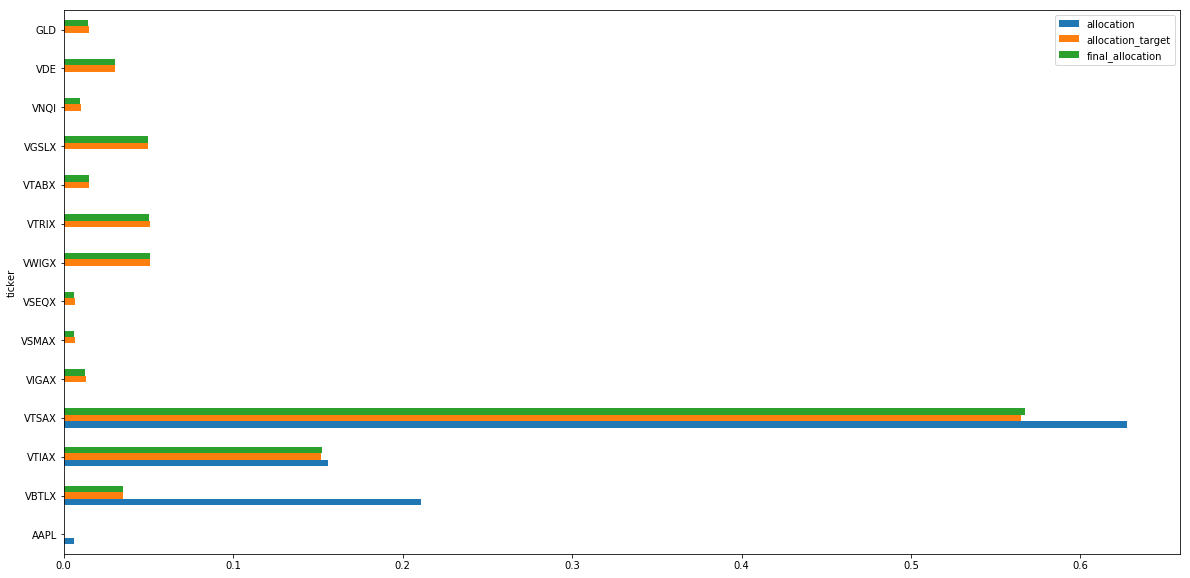

In [16]:
#Lets add a bar chart here to show the new allocation vs. the target allocation and vs. the original portfolio
graph_port = exec_port[['ticker','allocation','allocation_target','final_allocation']].copy()
graph_port.plot.barh(x='ticker',figsize=(20,10))

In [17]:
#Next we turn our ticker-level strategy into account level actions
#Join in our rebalanced portfolio and determine how to split value across accounts for a given ticker
port = pd.merge(start_port[['accounttype','accountid','ticker','shares']], 
                   exec_port[['ticker','assetclass','close','value','final_shares_chg','new_shares','new_value','new_value_chg','final_allocation']], 
                   how = 'right', 
                   left_on = 'ticker', 
                   right_on = 'ticker')
port['value_orig'] = port.close * port.shares
#Calculate the value-weight of each ticker by account
port['tick_alloc'] = port.value_orig / port.value #What pct of each ticker is in a given account?
port['tick_alloc'].fillna(1.0,inplace=True)

#check our sub-allocations
assert(port.groupby('ticker').tick_alloc.sum().sum() == len(port.groupby('ticker').tick_alloc.sum()))

#Recalculate the values proportionately
port['final_shares_chg_n'] = port.final_shares_chg * port.tick_alloc
port['new_shares_n'] = port.new_shares * port.tick_alloc
port['new_value_n'] = port.new_value * port.tick_alloc
port['new_value_chg_n'] = port.new_value_chg * port.tick_alloc
port['final_allocation_n'] = port.final_allocation * port.tick_alloc

#double check our final_allocation is 100%
assert(np.round(port.final_allocation_n.sum(),4)==1.0)

#Now we must double check to ensure we are not allocating buys to accounts with no sells (we cannot just add funds to a Traditional IRA account, for example)
#accounts with single securities in them which also exist in other accounts can cause issues if we don't do this
acctsdf = port.groupby(['accountid','accounttype']).new_value_chg_n.sum()
acctsdf = acctsdf.reset_index().rename(columns={'new_value_chg_n':'new_value_chg_sum'})
errordf = acctsdf[acctsdf.new_value_chg_sum > 0].copy() #a value >0 at the account-level implies we have allocated buys to an account with insufficient sells
erroraccts = errordf.accountid.values
if len(errordf) > 0: 
    for t in port[port.accountid.isin(erroraccts)].ticker.unique(): #Loop by security (not by account)
        print("Correcting distribution for single-security accounts edge case: {}".format(t))
        index = (port.accountid.isin(erroraccts)) & (port.ticker == t)
        display(port[port.ticker == t])
        #adjust numerator and denominator for proper recalculation of asset distribution across accounts
        port.loc[index,'new_shares_n'] = port.new_shares_n - port.final_shares_chg_n
        port.loc[index,'new_value_n'] = port.new_value_n - port.new_value_chg_n
        port.loc[index,'final_shares_chg_n'] = 0
        port.loc[index,'new_value_chg_n'] = 0

        #remove from denominator
        port.loc[port.ticker == t,'value'] = port.loc[port.ticker == t,'value'] - port[index].value_orig.sum()
        
        #recalculate values for this ticker
        port.loc[port.ticker == t,'tick_alloc'] = port[port.ticker == t].value_orig / port[port.ticker == t].value
        port.loc[index,'tick_alloc'] = 0 #set new money allocation to zero for funds with insufficient assets
        port.loc[port.ticker == t,'final_shares_chg_n'] = port.final_shares_chg * port.tick_alloc
        port.loc[port.ticker == t,'new_shares_n'] = port.shares + port.final_shares_chg_n
        port.loc[port.ticker == t,'new_value_chg_n'] = port.new_value_chg * port.tick_alloc
        port.loc[port.ticker == t,'new_value_n'] = port.value_orig + port.new_value_chg_n
        port.loc[port.ticker == t,'final_allocation_n'] = (port.new_value_n / port.new_value) * port.final_allocation
        
        display(port[port.ticker == t])

#Cleanup
port['value'] = port.value_orig
port['final_shares_chg'] = port.final_shares_chg_n
port['new_shares'] = port.new_shares_n
port['new_value'] = port.new_value_n
port['new_value_chg'] = port.new_value_chg_n
port['final_allocation'] = port.final_allocation_n
port.drop(['value_orig','tick_alloc','final_shares_chg_n','new_shares_n','new_value_n','new_value_chg_n','final_allocation_n'],axis=1,inplace=True)
port.fillna({'value':0.0},inplace=True)

#Check our work
assert(np.round(port.final_allocation.sum(),4)==1.0)
assert(np.round(np.sum((port.shares+port.final_shares_chg)-port.new_shares))==0)
assert(np.round(np.sum(port.new_value-(port.new_shares*port.close)))==0)
assert(np.round(np.sum(port.new_value_chg-(port.final_shares_chg*port.close)))==0)

#Lets look at our final portfolio at the account level
display(port)

accounttype accountid ticker   shares assetclass   close        value  \
0         RIRA      1111  VBTLX  913.483         BD   10.39   9491.08837   
1         RIRA      2222  VBTLX  772.407         BD   10.39   8025.30873   
2         RIRA      1111  VTIAX  514.298         ST   25.17  12944.88066   
3         RIRA      1111  VTSAX  151.121         ST   61.08   9230.47068   
4         RIRA      2222  VTSAX  151.578         ST   61.08   9258.38424   
5         TAXB      3333  VTSAX  549.871         ST   61.08  33586.12068   
6         TAXB      3333   AAPL    3.140         ST  156.15    490.31100   
7          NaN       NaN  VIGAX      NaN         ST   68.02      0.00000   
8          NaN       NaN  VSMAX      NaN         ST   62.25      0.00000   
9          NaN       NaN  VSEQX      NaN         ST   26.77      0.00000   
10         NaN       NaN  VWIGX      NaN         ST   24.76      0.00000   
11         NaN       NaN  VTRIX      NaN         ST   31.91      0.00000   
12         NaN       NaN  VTABX      NaN         BD   21.66      0.00000   
13         NaN       NaN  VGSLX      NaN         RE  105.06      0.00000   
14         NaN       NaN   VNQI      NaN         RE   52.05      0.00000   
15         NaN       NaN    VDE      NaN         ST   77.44      0.00000   
16         NaN       NaN    GLD      NaN         CS  120.57      0.00000   

    final_shares_chg  new_shares     new_value  new_value_chg  \
0        -743.404775  170.078225   1767.112759   -7723.975611   
1        -628.595225  143.811775   1494.204341   -6531.104389   
2          47.000000  561.298000  14127.870660    1182.990000   
3           1.418028  152.539028   9317.083821      86.613141   
4           1.422316  153.000316   9345.259305      86.875065   
5           5.159656  555.030656  33901.272475     315.151795   
6          -3.140000    0.000000      0.000000    -490.311000   
7          17.000000   17.000000   1156.340000    1156.340000   
8           9.000000    9.000000    560.250000     560.250000   
9          22.000000   22.000000    588.940000     588.940000   
10        190.000000  190.000000   4704.400000    4704.400000   
11        147.000000  147.000000   4690.770000    4690.770000   
12         64.000000   64.000000   1386.240000    1386.240000   
13         44.000000   44.000000   4622.640000    4622.640000   
14         17.000000   17.000000    884.850000     884.850000   
15         36.000000   36.000000   2787.840000    2787.840000   
16         11.000000   11.000000   1326.270000    1326.270000   

    final_allocation  
0           0.019071  
1           0.016125  
2           0.152468  
3           0.100550  
4           0.100854  
5           0.365862  
6           0.000000  
7           0.012479  
8           0.006046  
9           0.006356  
10          0.050770  
11          0.050623  
12          0.014960  
13          0.049887  
14          0.009549  
15          0.030086  
16          0.014313

In [18]:
#Finally, all new tickers need an account to land in
dport = None
acctsdf = None
if len(port[port.accounttype.isnull()])>0: #if we have none, skip this step
    print('Distributing new securities to existing accounts . . .')
    dport = port.copy()

    #account-level fund surplus or deficit - must match these with our orphaned securities
    acctsdf = port.groupby(['accountid','accounttype']).new_value_chg.sum()
    acctsdf = acctsdf.reset_index().rename(columns={'new_value_chg':'new_value_chg_sum'})
    #establish sort order so we can allocate tax-efficient account space first
    actype_sortorder = pd.DataFrame(data=[['RIRA',1],['TIRA',2],['TAXB',3]],columns=['accounttype','order'])
    acctsdf = pd.merge(acctsdf,actype_sortorder,how='left',left_on='accounttype',right_on='accounttype')
    #We make a consequential assumption here that any new_money_in will be allocated 100% in one of the Taxable accounts (first in list).
    #if you have a Roth-IRA which has not met its contribution limits for the year, it may be preferrential to distribute the funds there first.
    #IF YOU HAVE NO TAXABLE ACCOUNT AND YOU WISH TO REBALANCE WITH new_money_in > 0 this will cause errors - so we assert here:
    assert(new_money_in == 0 or (len(acctsdf[acctsdf.accounttype == 'TAXB'])>0 and new_money_in > 0))
    min_idx = acctsdf[acctsdf.accounttype == 'TAXB'].index.min()
    acctsdf.loc[min_idx,'new_value_chg_sum'] = acctsdf.loc[min_idx,'new_value_chg_sum'] - new_money_in
    #only return accounts that have space
    acctsdf = acctsdf[acctsdf.new_value_chg_sum<0].copy()

    #establish sort order so we can allocate tax-inefficient assets first
    aclass_sortorder = pd.DataFrame(data=[['ST',3],['BD',1],['CS',4],['RE',2],['ALT',5]],columns=['assetclass','order'])
    dport = pd.merge(dport,aclass_sortorder,how='left',left_on='assetclass',right_on='assetclass')

    #We loop twice, first to fit whole securities in accounts with tax location in mind, then again without tax location for anything leftover
    loop = 0
    while loop < 2:
        loop+=1
        #loop through orphaned tickers and place them in accounts until all assets are allocated or we are forced to split a security across accounts
        #  in the first loop we do not allow tax-inefficient assets to wind up in Taxable accounts, in the second loop we relax this constraint
        for index, row in dport[dport.accounttype.isnull()].sort_values(['order','new_value_chg'],ascending=[True,False]).iterrows():
            #loop through accounts and place the assets
            for i, r in acctsdf.iterrows():
                aid = r.accountid
                atype = r.accounttype
                bal = r.new_value_chg_sum
                #print('Evaluating {}-{} with {} starting bal'.format(aid,atype,bal))
                if loop == 0 and (row.assetclass in ('BD','RE') and atype == 'TAXB'):
                    continue #skip this case, since we don't want to place Bonds and Real-Estate assets in Taxable accounts
                elif loop == 0 and (row.assetclass not in ('BD','RE') and atype != 'TAXB'):
                    continue #skip this case, since we don't want to place tax-efficient assets into tax sheltered accounts 

                if row.new_value_chg + bal <=0: #it fits
                    bal+=row.new_value_chg
                    print(' FITS {} in {}-{} with {} remaining'.format(row.ticker,aid,atype,bal))
                    #update our portfolio
                    dport.loc[index,'accountid'] = aid
                    dport.loc[index,'accounttype'] = atype
                    #update account bal for next loop
                    acctsdf.loc[i,'new_value_chg_sum'] = bal
                    break
                else:
                    print(' {} {} does not fit in {}-{}'.format(row.ticker,row.new_value_chg,aid,atype))
    
    print('\nLets see what remains in our accounts after 2 loops . . .')
    display(acctsdf)
                    
    #Here we are forced to split a security across multiple accounts because no one account can fit it
    #  in this loop we allow tax-inefficient assets to wind up in Taxable accounts, but only as a last resort
    if len(dport[dport.accounttype.isnull()])>0:
        print('Splitting remaining securities across accounts . . .')
        #loop through accounts and place portions of asset in each, create a new row in the df for each placement.
        for index, row in dport[dport.accounttype.isnull()].sort_values(['order','new_value_chg'],ascending=[True,False]).iterrows():
            final_shares_chg = row.final_shares_chg
            asset_bal = row.new_value_chg
            #if its a tax-inefficent asset, order the accounts by 'order'
            if row.assetclass in ('BD','RE'):
                acctsdf = acctsdf.sort_values('order',ascending=True)
            else:
                acctsdf = acctsdf.sort_values('order',ascending=False)
            
            for i, r in acctsdf.iterrows():
                bal = r.new_value_chg_sum
                if asset_bal>-bal:
                    to_move = -bal
                    pct_move = -bal/row.new_value_chg
                    asset_bal+=bal
                else:
                    to_move = asset_bal
                    pct_move = asset_bal/row.new_value_chg
                    asset_bal=0
                print(' {} move {} or {}% into account {}-{}. {} bal remaining {}'.format(row.ticker,to_move,pct_move,r.accountid,r.accounttype,row.ticker,asset_bal))
                
                #update our account to reflect this change
                if asset_bal > 0:
                    acctsdf.loc[i,'new_value_chg_sum'] = 0.0
                else:
                    acctsdf.loc[i,'new_value_chg_sum'] = to_move+bal
                
                if (np.floor(pct_move*row.new_shares)*row.close)-row.value > 0:
                    #create new row in our portfolio for this asset in this account
                    dport.loc[max(dport.index)+1] = [r.accounttype,
                                            r.accountid,
                                            row.ticker,
                                            row.shares,
                                            row.assetclass,
                                            row.close,
                                            row.value,
                                            np.floor(pct_move*row.final_shares_chg), #we round down to get back to whole shares
                                            np.floor(pct_move*row.new_shares),
                                            np.floor(pct_move*row.new_shares)*row.close,
                                            (np.floor(pct_move*row.new_shares)*row.close)-row.value, #rounding can cause us to be short of our total allocatable funds
                                            np.floor(pct_move*row.new_value)/dport.new_value.sum(),
                                            row.order]
    
                #finally delete the original row from the df
                dport.drop(dport[dport.accounttype.isnull()].index,inplace=True)
            
                #double check our work - we just care that distributed funds < total available funds for this ticker
                assert(dport[dport.ticker==row.ticker].new_value_chg.sum() < row.new_value_chg)

Distributing new securities to existing accounts . . .
 FITS VTABX in 1111-RIRA with -5068.132470695083 remaining
 FITS VGSLX in 1111-RIRA with -445.4924706950824 remaining
 VNQI 884.8499999999999 does not fit in 1111-RIRA
 FITS VNQI in 2222-RIRA with -5559.379323808596 remaining
 VWIGX 4704.400000000001 does not fit in 1111-RIRA
 FITS VWIGX in 2222-RIRA with -854.9793238085958 remaining
 VTRIX 4690.77 does not fit in 1111-RIRA
 VTRIX 4690.77 does not fit in 2222-RIRA
 FITS VTRIX in 3333-TAXB with -5484.389205496322 remaining
 VDE 2787.84 does not fit in 1111-RIRA
 VDE 2787.84 does not fit in 2222-RIRA
 FITS VDE in 3333-TAXB with -2696.5492054963215 remaining
 VIGAX 1156.34 does not fit in 1111-RIRA
 VIGAX 1156.34 does not fit in 2222-RIRA
 FITS VIGAX in 3333-TAXB with -1540.2092054963216 remaining
 VSEQX 588.9399999999999 does not fit in 1111-RIRA
 FITS VSEQX in 2222-RIRA with -266.0393238085959 remaining
 VSMAX 560.25 does not fit in 1111-RIRA
 VSMAX 560.25 does not fit in 2222-RIRA


accountid accounttype  new_value_chg_sum  order
0      1111        RIRA        -445.492471      1
1      2222        RIRA        -266.039324      1
2      3333        TAXB        -979.959205      3

Splitting remaining securities across accounts . . .
 GLD move 979.9592054963216 or 0.7388836402062338% into account 3333-TAXB. GLD bal remaining 346.3107945036784
 GLD move 346.3107945036784 or 0.26111635979376624% into account 1111-RIRA. GLD bal remaining 0
 GLD move 0 or 0.0% into account 2222-RIRA. GLD bal remaining 0


In [19]:
#Lets see whats left in our accounts, it should be very close to zero
if acctsdf is not None:
    display(acctsdf)

accountid accounttype  new_value_chg_sum  order
2      3333        TAXB           0.000000      3
0      1111        RIRA         -99.181676      1
1      2222        RIRA        -266.039324      1

In [20]:
#Review our final portfolio with recommended buys/sells in 'final_shares_chg' column
if dport is not None:
    #Cleanup
    dport.drop(columns=['order'],inplace=True)
    dport = dport[['accounttype','accountid','ticker','shares','assetclass','close','value','new_shares','final_shares_chg','new_value','new_value_chg','final_allocation']]
    display(dport)
else:
    port = port[['accounttype','accountid','ticker','shares','assetclass','close','value','new_shares','final_shares_chg','new_value','new_value_chg','final_allocation']]
    display(port)

accounttype accountid ticker   shares assetclass   close        value  \
0         RIRA      1111  VBTLX  913.483         BD   10.39   9491.08837   
1         RIRA      2222  VBTLX  772.407         BD   10.39   8025.30873   
2         RIRA      1111  VTIAX  514.298         ST   25.17  12944.88066   
3         RIRA      1111  VTSAX  151.121         ST   61.08   9230.47068   
4         RIRA      2222  VTSAX  151.578         ST   61.08   9258.38424   
5         TAXB      3333  VTSAX  549.871         ST   61.08  33586.12068   
6         TAXB      3333   AAPL    3.140         ST  156.15    490.31100   
7         TAXB      3333  VIGAX      NaN         ST   68.02      0.00000   
8         TAXB      3333  VSMAX      NaN         ST   62.25      0.00000   
9         RIRA      2222  VSEQX      NaN         ST   26.77      0.00000   
10        RIRA      2222  VWIGX      NaN         ST   24.76      0.00000   
11        TAXB      3333  VTRIX      NaN         ST   31.91      0.00000   
12        RIRA      1111  VTABX      NaN         BD   21.66      0.00000   
13        RIRA      1111  VGSLX      NaN         RE  105.06      0.00000   
14        RIRA      2222   VNQI      NaN         RE   52.05      0.00000   
15        TAXB      3333    VDE      NaN         ST   77.44      0.00000   
17        TAXB      3333    GLD      NaN         CS  120.57      0.00000   
18        RIRA      1111    GLD      NaN         CS  120.57      0.00000   

    new_shares  final_shares_chg     new_value  new_value_chg  \
0   170.078225       -743.404775   1767.112759   -7723.975611   
1   143.811775       -628.595225   1494.204341   -6531.104389   
2   561.298000         47.000000  14127.870660    1182.990000   
3   152.539028          1.418028   9317.083821      86.613141   
4   153.000316          1.422316   9345.259305      86.875065   
5   555.030656          5.159656  33901.272475     315.151795   
6     0.000000         -3.140000      0.000000    -490.311000   
7    17.000000         17.000000   1156.340000    1156.340000   
8     9.000000          9.000000    560.250000     560.250000   
9    22.000000         22.000000    588.940000     588.940000   
10  190.000000        190.000000   4704.400000    4704.400000   
11  147.000000        147.000000   4690.770000    4690.770000   
12   64.000000         64.000000   1386.240000    1386.240000   
13   44.000000         44.000000   4622.640000    4622.640000   
14   17.000000         17.000000    884.850000     884.850000   
15   36.000000         36.000000   2787.840000    2787.840000   
17    8.000000          8.000000    964.560000     964.560000   
18    2.000000          2.000000    241.140000     241.140000   

    final_allocation  
0           0.019071  
1           0.016125  
2           0.152468  
3           0.100550  
4           0.100854  
5           0.365862  
6           0.000000  
7           0.012479  
8           0.006046  
9           0.006356  
10          0.050770  
11          0.050623  
12          0.014960  
13          0.049887  
14          0.009549  
15          0.030086  
17          0.010565  
18          0.003749

## Conclusion
Through this portfolio rebalancing demonstration using Pandas you can see we have achieved a rebalanced portfolio very closely approximating our desired target allocation. We can see how GLD was added as a new security along with 9 others, and AAPL was removed from the portfolio. The remaining securities were bought or sold as required by our target allocation. We accounted for whole-share rounding because most of our assets in this sample are index funds. The final steps had us consider how to distribute newly acquired securities into existing accounts, this was accomplished through iteratively fitting securities into accounts until they all had a home. This simple rebalancer can be adapted to your needs and I urge you grab the code and see if you can improve upon it. I welcome your thoughts or feedback in the comments.  

***No Solicitation or Investment Advice:***
The material contained on this website is for informational purposes only and the author is not soliciting any action based upon such material. The material is not to be construed as an offer or a recommendation to buy or sell a security nor is it to be construed as investment advice. Additionally, the material accessible through this website does not constitute a representation that the investments described herein are suitable or appropriate for any person. This code is provided as-is with no warranties and may contain errors which affect its performance.